# **Load Data & Import Libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report

In [ ]:
fake = pd.read_csv('/content/drive/MyDrive/Bootcamp/PROJECT/Fake News Detection/Fake.csv')
real = pd.read_csv('/content/drive/MyDrive/Bootcamp/PROJECT/Fake News Detection/True.csv')

# **Preliminary Look at the Data**

In [ ]:
# Load fake news dataset
fake.head(3)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"


In [ ]:
# Load real news dataset
real.head(3)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"


- There are two datasets, one is all fake news and one is real news.
- The datasets can be merged, before that I need to add new column to classify fake and real news, it will called `class` as target.

In [ ]:
# Insert class column for each dataset, 0 for fake news, and 1 for true news
fake["class"] = 0
real["class"] = 1

In [ ]:
# Merge two datasets into one dataframe
news = pd.concat([fake, real], axis =0)
news.sample(3)

,title,text,subject,date,class
21387,Former Libyan prime minister freed after abduc...,TRIPOLI (Reuters) - Former Libyan Prime Minist...,worldnews,"August 23, 2017",1
1906,Wal-Mart reopens most Gulf region stores after...,(Reuters) - Wal-Mart Stores Inc said on Monday...,politicsNews,"September 4, 2017",1
15372,IS HILLARY GOING DOWN IN FLAMES? Latest Poll S...,The good news is the Clinton Crime Syndicate i...,politics,"Aug 4, 2015",0


Two datasets already merged. Now I will remove unecessary columns, and only left two columns; `text` and `class`.

In [ ]:
# Remove not required columns
news = news.drop(['title', 'subject', 'date'], axis = 1)
news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44898 non-null  object
 1   class   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ MB


There are 44898 data rows, and it seems no missing value

In [ ]:
# Random Shuffle the columns

news = news.sample(frac = 1)
news.head(3)

,text,class
16312,GENEVA (Reuters) - Myanmar authorities have ag...,1
19516,"Bill Penzey, the owner of Penzeys Spices, wrot...",0
18897,,0


In [ ]:
# Reset index
news.reset_index(inplace = True)
news.drop(['index'], axis = 1, inplace = True)

In [ ]:
news.head(3)

,text,class
0,GENEVA (Reuters) - Myanmar authorities have ag...,1
1,"Bill Penzey, the owner of Penzeys Spices, wrot...",0
2,,0


# **Text Processing**

I can’t use text data directly because it has some unusable words and special symbols and many more things. So that I have to always first processing text data such as Lemmatization and stopwords.

In [ ]:
ps = WordNetLemmatizer()

In [ ]:
nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
def cleaning_data(row):
    
    # convert text to lower case
    row = row.lower()
    
    # Only take words from text and remove number and special character using RegX
    row = re.sub('[^a-zA-Z]' , ' ' , row)
    
    # split the data and make token.
    token = row.split()
    
    # lemmatize the word and remove stop words
    lmtz = [ps.lemmatize(word) for word in token if not word in stopwords]  
    
    # join all the token with space
    cleanned_news = ' '.join(lmtz) 
    
    return cleanned_news

In [ ]:
news['text'] = news['text'].apply(lambda x : cleaning_data(x))

In [ ]:
news.head(10)

,text,class
0,geneva reuters myanmar authority agreed allow ...,1
1,bill penzey owner penzeys spice wrote two sepa...,0
2,,0
3,mass live ayyadurai announced republican u sen...,0
4,even fox news begin call gun control clear sig...,0
5,jerusalem reuters israeli parliament voted mon...,1
6,campaign trail donald trump promised revive co...,0
7,new york reuters u democratic presidential can...,1
8,disrupt inauguration majority spoken nearly mi...,0
9,tax really kill people eric garner perfect exa...,0


# **Model Training**

After processing the text data, I will train the model use 3 algorithm classifications;
- Logistic Regression
- Random Forest
- Passive-Aggressive Classifier

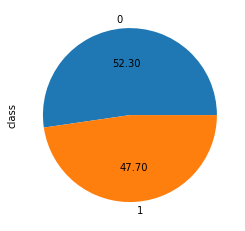

In [ ]:
# Check value counts
news['class'].value_counts().plot.pie(autopct='%.2f')

The data is imbalance with fake news quantity more than true news. So I will use F1 score instead (to seek a balance between Precision and Recall and there is an uneven class distribution).

In [ ]:
# Split train-test data with proportion 80:20
x = news['text']
y = news['class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Before do model training, I have to compute all text data in `text` column train and test data. To do that, I will convert a collection of raw documents to a matrix of TF-IDF features using Vectorizer.

In [ ]:
vectorize = TfidfVectorizer(max_features = 50000 , lowercase=False , ngram_range=(1,2))
xv_train = vectorize.fit_transform(x_train)
xv_test = vectorize.transform(x_test)

In [ ]:
# Logistic Regression

logreg = LogisticRegression(random_state=42)
logreg.fit(xv_train,y_train)

LogisticRegression(random_state=42)

In [ ]:
# Random Forest

RF = RandomForestClassifier(random_state=42)
RF.fit(xv_train,y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Passive Aggressive Classifier
PAC = PassiveAggressiveClassifier(random_state=42)
PAC.fit(xv_train,y_train)

PassiveAggressiveClassifier(random_state=42)

# **Model Evaluation**

After train the data use 3 model algorithm, I will evaluate each model to see which the best algorithm to fake or real news prediction.

In [ ]:
# Logistic Regression Evaluation
logreg_pred = logreg.predict(xv_test)

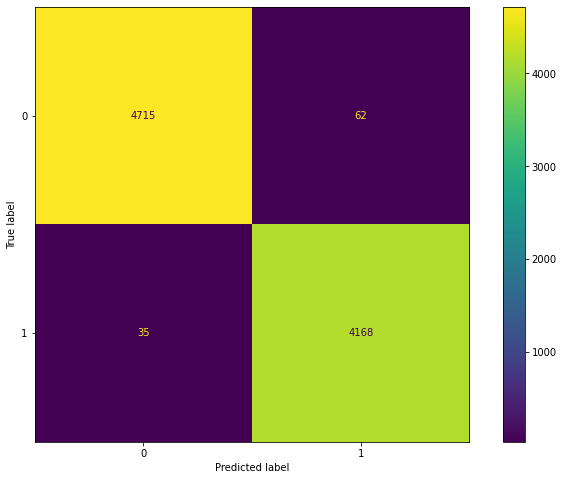

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

cm = confusion_matrix(y_test, logreg_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot(ax=ax)
plt.show()

In [ ]:
print(classification_report(y_test, logreg_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4777
           1       0.99      0.99      0.99      4203

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
print('Logistic Regression F1 score is',f1_score(y_test, logreg_pred)*100)

Logistic Regression F1 score is 98.84975690738764


In [ ]:
# Random Forest Evaluation
RF_pred = RF.predict(xv_test)

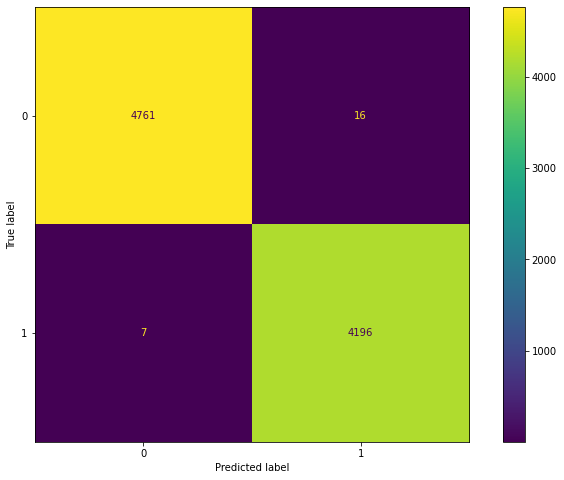

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

cm = confusion_matrix(y_test, RF_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot(ax=ax)
plt.show()

In [ ]:
print(classification_report(y_test, RF_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4777
           1       1.00      1.00      1.00      4203

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
print('Random Forest F1 score is',f1_score(y_test, RF_pred)*100)

Random Forest F1 score is 99.72667855020796


In [ ]:
# Passive Aggressive Classifier Evaluation
PAC_pred = PAC.predict(xv_test)

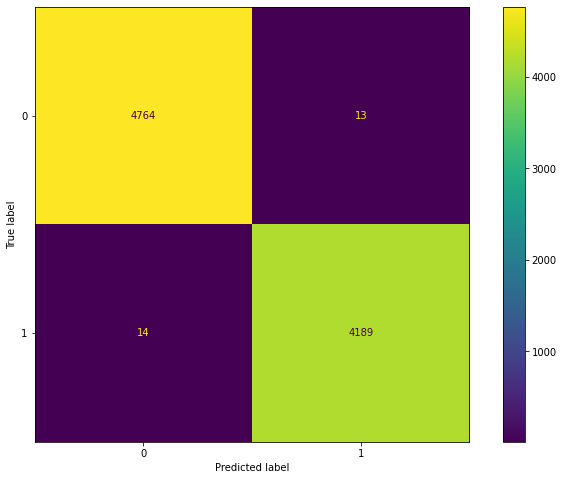

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

cm = confusion_matrix(y_test, PAC_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=[0,1])
disp.plot(ax=ax)
plt.show()

In [ ]:
print(classification_report(y_test, PAC_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4777
           1       1.00      1.00      1.00      4203

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [ ]:
print('Passive Aggressive Classifier F1 score is',f1_score(y_test, PAC_pred)*100)

Passive Aggressive Classifier F1 score is 99.67876264128495


- All three classification algorithms have good performance (> 95%), and all of them can detect true positive and negative with high percentation.
- From F1 score, I rank three classification algorithms from the performance score is **Random Forest** (99.73%), **Passive-Aggressive Classifier** (99.68%) and **Logistic Regression** (98.85%).